# Generic dictionary learning

Reference: [Dictionary Learning](http://scikit-learn.org/stable/modules/decomposition.html#dictionarylearning)

Dictionary learning is a matrix factorization problem that amounts to finding a(usually overcomplete) dictionary that will perform good at sparsely encoding the fitted data.

Representing data as sparse combinations of atoms from an overcomplete dictionary is suggested to be the way the mammal primary visual cortex works. Consequently, dictionary learning applied on image patches has been shown to give good results in image processing tasks such as image completion, inpainting and denoising, as well as for supervised recognition tasks.

Dictionary learning is an optimization problem solved by alternatively updating the sparse code, as a solution to multiple Lasso problems, considering the dictionary fixed, and then updating the dictionary to best fit the sparse code.

$$(U^,V^) = argmin_{(U,V)} 0.5 || Y - U V ||_2^2 + alpha * || U ||_1$$

  with $|| V_k ||_2 = 1$ for all  $0 <= k < n_{components}$

After using such a procedure to fit the dictionary, the transform is simply a sparse coding step that shares the same implementation with all dictionary learning objects(see Sparse coding with a precomputed dictionary).

Using: [sklearn.decomposition.DictionaryLearning](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.DictionaryLearning.html)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
from skimage import io
import matplotlib.pylab as plt
import notebooks.notebook_utils as uts

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## load datset

loading dataset: (True) exists -> /mnt/30C0201EC01FE8BC/TEMP/atomicPatternDictionary_v0/datasetFuzzy_raw
loading (True) <- /mnt/30C0201EC01FE8BC/TEMP/atomicPatternDictionary_v0/dictionary/atlas.png


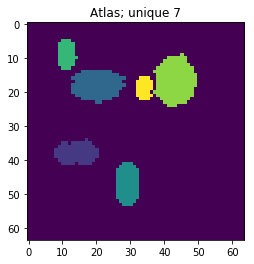

In [2]:
p_dataset = os.path.join(uts.DEFAULT_PATH, uts.SYNTH_DATASETS_FUZZY[0])
print ('loading dataset: ({}) exists -> {}'.format(os.path.exists(p_dataset), p_dataset))

p_atlas = os.path.join(uts.DEFAULT_PATH, 'dictionary/atlas.png')
atlas_gt = io.imread(p_atlas)
nb_patterns = len(np.unique(atlas_gt))
print ('loading ({}) <- {}'.format(os.path.exists(p_atlas), p_atlas))
plt.imshow(atlas_gt, interpolation='nearest')
_ = plt.title('Atlas; unique %i' % nb_patterns)

In [3]:
list_imgs = uts.load_dataset(p_dataset)
print ('loaded # images: ', len(list_imgs))
img_shape = list_imgs[0].shape
print ('image shape:', img_shape)

loaded # images:  800
image shape: (64, 64)


## Pre-Processing

input data shape: (800, 4096)


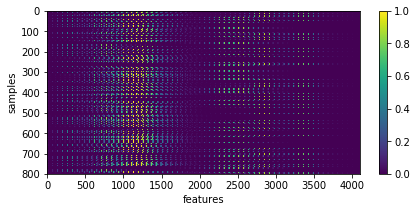

In [5]:
X = np.array([im.ravel() for im in list_imgs]) # - 0.5
print ('input data shape:', X.shape)

plt.figure(figsize=(7, 3))
_= plt.imshow(X, aspect='auto'), plt.xlabel('features'), plt.ylabel('samples'), plt.colorbar()

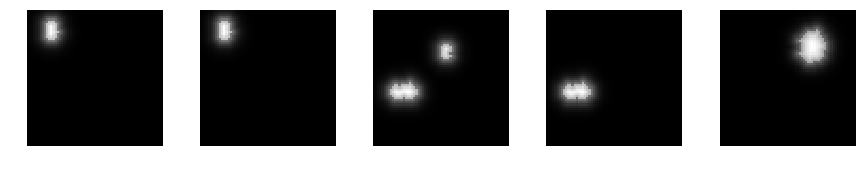

In [6]:
uts.show_sample_data_as_imgs(X, img_shape, nb_rows=1, nb_cols=5)

## Generic dictionary learning

In [7]:
from sklearn.decomposition import DictionaryLearning
dl = DictionaryLearning(n_components=nb_patterns, fit_algorithm='lars', transform_algorithm='omp', 
                        n_jobs=-1, max_iter=200, split_sign=False)

X_new = dl.fit_transform(X[:1200, :])
print ('fitting parameters:', dl.get_params())
print ('number of iteration:', dl.n_iter_)

fitting parameters: {'n_jobs': -1, 'code_init': None, 'max_iter': 200, 'dict_init': None, 'fit_algorithm': 'lars', 'random_state': None, 'n_components': 7, 'tol': 1e-08, 'transform_algorithm': 'omp', 'alpha': 1, 'transform_alpha': None, 'transform_n_nonzero_coefs': None, 'split_sign': False, 'verbose': False}
number of iteration: 50


**show the estimated components - dictionary**

estimated component matrix: (7, 4096)


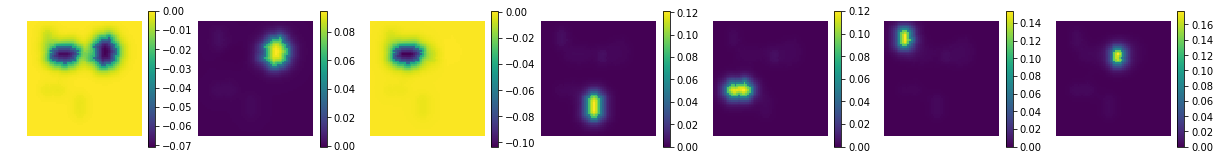

In [8]:
comp = dl.components_
coefs = np.sum(np.abs(X_new), axis=0)
print ('estimated component matrix:', comp.shape)

compSorted = [c[0] for c in sorted(zip(comp, coefs), key=lambda x: x[1], reverse=True) ]
uts.show_sample_data_as_imgs(np.array(compSorted), img_shape, nb_cols=nb_patterns, bool_clr=True)

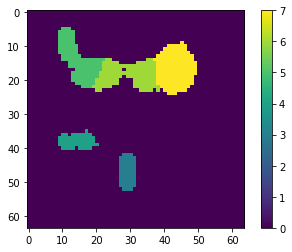

In [9]:
ptn_used = np.sum(np.abs(X_new), axis=0) > 0
atlas_ptns = comp[ptn_used, :].reshape((-1, ) + list_imgs[0].shape)

atlas_ptns = comp.reshape((-1, ) + list_imgs[0].shape)
atlas_estim = np.argmax(atlas_ptns, axis=0) + 1
atlas_sum = np.sum(np.abs(atlas_ptns), axis=0)
atlas_estim[atlas_sum < 1e-1] = 0
_ = plt.imshow(atlas_estim, interpolation='nearest'), plt.colorbar()

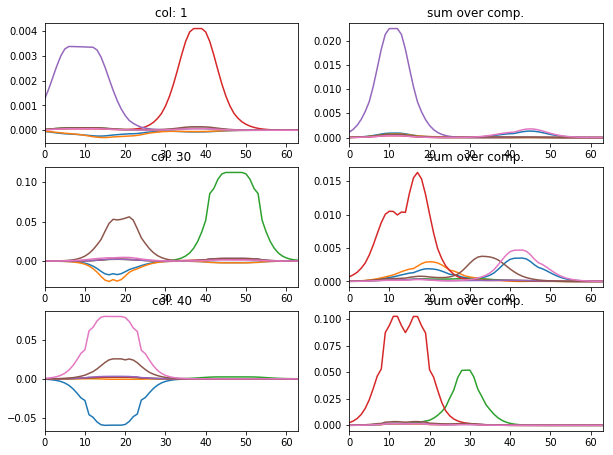

In [10]:
l_idx = [1, 30, 40]
fig, axr = plt.subplots(len(l_idx), 2, figsize=(10, 2.5*len(l_idx)))
for i, idx in enumerate(l_idx):
    axr[i, 0].plot(atlas_ptns[:,:,idx].T), axr[i, 0].set_xlim([0, 63])
    axr[i, 0].set_title('col: {}'.format(idx))
    axr[i, 1].plot(np.abs(atlas_ptns[:,idx,:].T)), axr[i, 1].set_xlim([0, 63])
    axr[i, 1].set_title('sum over comp.')

**particular coding of each sample**

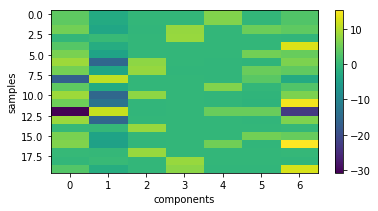

In [11]:
plt.figure(figsize=(6, 3))
plt.imshow(X_new[:20,:], interpolation='nearest', aspect='auto'), plt.colorbar()
_= plt.xlabel('components'), plt.ylabel('samples')

coefs = np.sum(np.abs(X_new), axis=0)
# print 'used coeficients:', coefs.tolist()

**backword reconstruction from encoding and dictionary**

In [12]:
res = np.dot(X_new, comp)
print ('model applies by reverting the unmixing', res.shape)

model applies by reverting the unmixing (200, 4096)


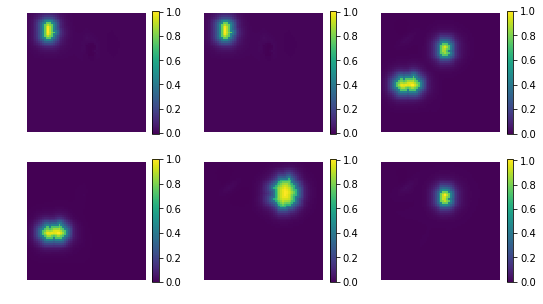

In [15]:
uts.show_sample_data_as_imgs(res, img_shape, nb_rows=2, nb_cols=3, bool_clr=True)